In [46]:
import xgboost
import shap 

import numpy as np
from cell_paint_seg.utils import get_id_to_path, check_valid_labels, threat_score
from cell_paint_seg.image_io import read_ims, read_seg
from skimage import io, exposure, measure, transform
from pathlib import Path
import napari
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score 
from PIL import Image

# Universal

In [25]:
def id_from_name_dataset(name):
    id = name[:-7]
    return id 

def condition_from_id(id):
    row_to_roid = {"B":0, "C":1, "D":2, "E":3, "F":4, "G":5}
    cond_to_cond = {1: "KPT", 2:"H2O2", 3:"Tunicamycin", 4:"Autophagt", 5:"DMSO"}

    well = id.split("_")[1]
    row = well[1]
    row = row_to_roid[row]
    col = int(well[2:])
    col -= 2

    conditions = [[1,1,2,2,5,1,1,4,5,5],
                  [3,3,4,4,5,2,2,4,3,3],
                  [5,2,2,1,1,2,2,3,3,5],
                  [3,3,4,4,5,5,4,4,1,1],
                  [4,4,1,1,3,2,2,1,3,3],
                  [5,5,2,2,3,5,5,1,4,4]]
    
    return conditions[row][col] - 1

path_dataset = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all_control/release/images"

channels = ["ER", "DNA", "Mito", "Actin", "RNA", "Golgi/membrane"]
res = 6.9e-7

id_to_path = get_id_to_path(path_dataset, tag=".tif", id_from_name=id_from_name_dataset)

print(f"{len(id_to_path.keys())} samples found")

360 samples found


# Make Dataset

In [ ]:
X = []
y = []
for id, paths in tqdm(id_to_path.items()):
    ims = read_ims(paths)
    ims = [transform.resize(im, (10,10)) for im in ims]
    ims = [im.flatten() for im in ims]
    x = np.concatenate(ims, axis=0)

    condition = condition_from_id(id)

    X.append(x)
    y.append(condition)

X = np.stack(X, axis=0)
columns = [f"{channel}_{i}" for channel in channels for i in range(ims[0].size)]

X = pd.DataFrame(X, columns=columns)
X.shape  

  0%|          | 0/360 [00:00<?, ?it/s]

(360, 600)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15, stratify=y)

# Predict

In [45]:
model = xgboost.XGBClassifier().fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
acc

0.3055555555555556

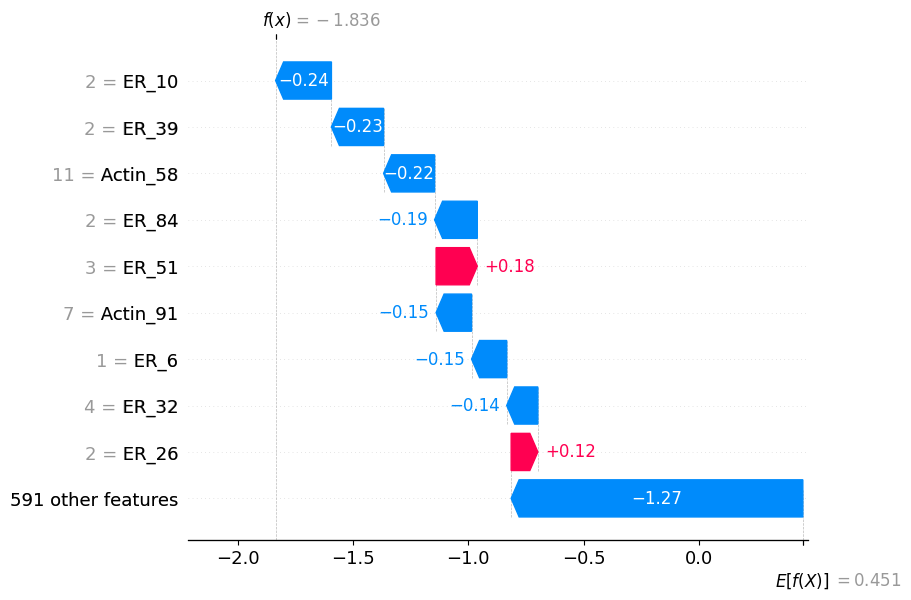

In [41]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0,:,0])

In [42]:
y

[3,
 1,
 0,
 3,
 0,
 0,
 4,
 0,
 4,
 4,
 4,
 0,
 1,
 4,
 2,
 3,
 4,
 1,
 1,
 4,
 2,
 3,
 1,
 3,
 1,
 4,
 0,
 3,
 4,
 2,
 3,
 3,
 4,
 4,
 2,
 0,
 4,
 1,
 0,
 3,
 4,
 2,
 2,
 1,
 2,
 2,
 0,
 3,
 3,
 3,
 1,
 1,
 0,
 4,
 1,
 0,
 4,
 4,
 2,
 4,
 0,
 3,
 2,
 0,
 0,
 1,
 2,
 4,
 0,
 3,
 1,
 1,
 3,
 0,
 2,
 1,
 4,
 3,
 3,
 1,
 1,
 2,
 3,
 2,
 4,
 3,
 4,
 4,
 2,
 1,
 4,
 1,
 3,
 4,
 1,
 4,
 2,
 0,
 2,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 0,
 2,
 4,
 0,
 1,
 0,
 2,
 2,
 1,
 4,
 0,
 1,
 1,
 1,
 1,
 0,
 3,
 2,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 4,
 1,
 4,
 0,
 4,
 0,
 4,
 4,
 1,
 2,
 3,
 2,
 2,
 2,
 3,
 4,
 4,
 1,
 3,
 0,
 3,
 1,
 3,
 4,
 0,
 3,
 3,
 3,
 4,
 1,
 2,
 3,
 3,
 1,
 2,
 0,
 4,
 2,
 0,
 0,
 4,
 4,
 3,
 2,
 2,
 2,
 2,
 0,
 3,
 1,
 0,
 4,
 3,
 2,
 3,
 3,
 0,
 1,
 4,
 2,
 2,
 0,
 3,
 1,
 0,
 4,
 0,
 0,
 0,
 0,
 4,
 0,
 1,
 1,
 3,
 1,
 0,
 2,
 2,
 0,
 4,
 4,
 4,
 0,
 1,
 4,
 0,
 4,
 1,
 1,
 3,
 0,
 2,
 0,
 2,
 1,
 3,
 4,
 3,
 1,
 4,
 4,
 0,
 2,
 3,
 2,
 3,
 0,
 4,
 2,
 4,
 2,
 1,
 1,
 0,
 3,
 1,
 3,
